In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [5]:
# X is the result of input vector after positional encoding has been applied - input to the multihead attention
x.size()

torch.Size([1, 4, 512])

In [6]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [7]:
qkv_layer

Linear(in_features=512, out_features=1536, bias=True)

In [8]:
qkv = qkv_layer(x)

In [10]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'QKV Distribution')

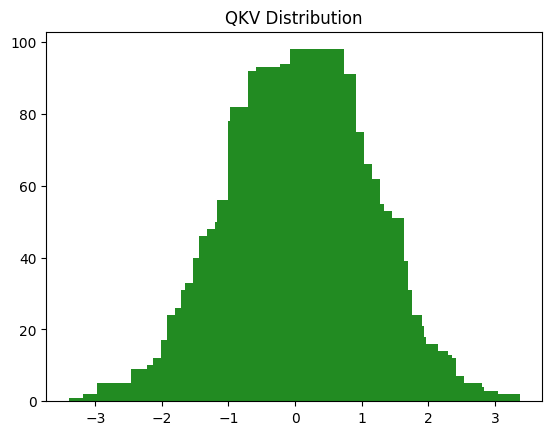

In [11]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title("QKV Distribution")

In [13]:
num_heads = 8
head_dim = d_model//num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [17]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [18]:
qkv = qkv.permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [19]:
qkv

tensor([[[[-0.7496,  0.3531,  0.2618,  ..., -0.1575, -0.9731, -0.0473],
          [ 0.6868, -0.2066, -0.0904,  ..., -0.4904,  0.0486, -0.3167],
          [ 0.4414,  0.7746,  0.4527,  ..., -0.6080, -0.5427, -0.8279],
          [ 0.1280,  0.5428, -0.5650,  ..., -1.2856,  0.7576,  0.1173]],

         [[-0.0799,  0.1622,  0.0173,  ...,  0.1272, -0.2408,  0.3202],
          [ 0.8238, -0.1900,  0.3532,  ..., -0.1221, -0.4424,  0.5339],
          [-0.6406,  0.5993,  0.4022,  ..., -0.0905, -0.5899, -0.0023],
          [-0.2388, -0.0415, -0.1882,  ..., -0.0021,  0.4028,  0.2902]],

         [[-0.4266, -0.0676,  0.0847,  ...,  0.0410, -0.2080, -0.0670],
          [-0.0909, -0.0112, -0.0895,  ...,  0.8887, -0.1615,  0.0969],
          [-0.0899,  1.1727,  0.0544,  ..., -0.7194, -0.2564, -0.6483],
          [ 0.5524,  0.6242,  1.3000,  ..., -0.2234, -0.4264, -0.3992]],

         ...,

         [[-1.2519, -1.1713, -0.1160,  ..., -0.3668, -0.5660, -0.1256],
          [-0.0847,  0.1512,  0.1538,  ...,

In [20]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [25]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [26]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [27]:
scaled+=mask

In [29]:
attention = F.softmax(scaled, dim=-1)

In [30]:
attention

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.2502, 0.7498, 0.0000, 0.0000],
          [0.2194, 0.1958, 0.5848, 0.0000],
          [0.1318, 0.1040, 0.2596, 0.5047]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.6243, 0.3757, 0.0000, 0.0000],
          [0.3048, 0.2522, 0.4430, 0.0000],
          [0.2686, 0.2210, 0.1484, 0.3621]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4630, 0.5370, 0.0000, 0.0000],
          [0.4000, 0.2289, 0.3712, 0.0000],
          [0.3158, 0.2000, 0.3120, 0.1722]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5392, 0.4608, 0.0000, 0.0000],
          [0.1475, 0.4920, 0.3605, 0.0000],
          [0.2692, 0.3087, 0.1780, 0.2441]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5034, 0.4966, 0.0000, 0.0000],
          [0.3507, 0.2665, 0.3828, 0.0000],
          [0.3517, 0.2890, 0.1306, 0.2286]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5004, 0.4996, 0.0000, 0.0000],
          [0.3122, 0.4

In [36]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [47]:
# Compile every thing in a single function

def scaled_dot_product(q, k, v, mask=False):
    
    def GenerateMask(scaled):
        mask = torch.full(scaled.size(), float('-inf'))
        mask = torch.triu(mask, diagonal=1)
        return mask
    
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if not mask:
        scaled += GenerateMask(scaled)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

def multi_head_attention(q, k, v, mask=False):
    values, attention = scaled_dot_product(q, k, v, mask)
    values = values.reshape(batch_size, sequence_length, num_heads*head_dim)
    linear_layer = nn.Linear(d_model, d_model)
    out = linear_layer(values)
    return out
    

In [41]:
values, attention = scaled_dot_product(q, k, v, True)

In [42]:
values = values.reshape(batch_size, sequence_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [43]:
linear_layer = nn.Linear(d_model, d_model)

In [44]:
out = linear_layer(values)

In [46]:
out

tensor([[[-0.0463,  0.0489, -0.0964,  ...,  0.1093,  0.2200,  0.0992],
         [ 0.3322,  0.1566,  0.0309,  ..., -0.0027, -0.1218,  0.0550],
         [ 0.0267, -0.1101,  0.1050,  ...,  0.1771,  0.3138, -0.2428],
         [ 0.2565, -0.2947,  0.2161,  ...,  0.1209, -0.0578,  0.1070]]],
       grad_fn=<ViewBackward0>)